In [2]:
import pandas as pd
import torch as T
import torch.nn as nn
import torch.nn.functional as ff
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
import pickle

import matplotlib.pyplot as plt

from dataclasses import dataclass
import json
from tqdm import tqdm
import numpy as np
import os
from typing import Sequence
from datetime import datetime, timedelta


pd.set_option('display.max_columns', None)
pd.set_option('future.no_silent_downcasting', True)

In [3]:
T.cuda.is_available()

True

# **Constants**

In [4]:
@dataclass(frozen=True)
class Pathes:
    anomalies1: str = '../main_datasets/processed_datasets/События за период_01.10.2023-31.12.2023.xlsx____uploading_table.csv'
    anomalies2: str = '../main_datasets/processed_datasets/События_за_период_01.01.2024-30.04.2024____uploading_table.csv'
    weather_data: str = '../main_datasets/exogens_params/weather_dataset_v2.csv'
    buildingsd_descriptions: str = '../main_datasets/processed_datasets/buildings_description_processed.csv'
    columns_info: str = "../columns_info.json"
    

In [5]:
with open(Pathes.columns_info) as f:
    d = json.load(f)
    @dataclass(frozen=True)
    class ColumnsInfo:
        usless_col = d['useless_columns']
        useless_by_classification = d['useless_by_classification']
        categorical_columns = d['categorical_columns']
        usfull_columns_in_buildings_data = d['usfull_columns_for_algorithms']['usfull_columns_in_buildings_data']
        usfull_columns_in_anomaly_ts = d['usfull_columns_for_algorithms']['usefull_columns_in_anomaly_ts']
        time_columns = d['time_columns']
        usefull_events = d["usefull_events"]
        columns_norm_forms = d['columns_norm_form_pairs']
        weathers_types = d['weathers_types']



In [6]:
p = '../factorized_objects/'
factorized_objects = dict()
for i in os.listdir(p):
    with open(p + i, 'r') as f:
        data = json.load(f)
        factorized_objects[i.split('.')[0]] = data



In [7]:
device = 'cuda'

In [8]:
factorized_objects.keys()

dict_keys(['№ ОДС', 'Марка счетчика', 'Материал', 'Статус адреса', 'Группа', 'Признак аварийности здания', 'Центральное отопление(контур)', 'Потребитель (или УК)', 'Потребители', 'Документ-основание регистрационных действий', 'Район', 'Назначение', 'Серии проектов', 'Номер ТП', 'Материалы кровли по БТИ', 'Материалы стен'])

# **Functions**

In [9]:
def make_timeline_for_year(year: int=2023):
    data_1 = np.arange(datetime(year=year, month=1, day=1), datetime(year=year, month=5, day=1), timedelta(hours=1)).tolist()
    data_2 = np.arange(datetime(year=year, month=10, day=1), datetime(year=year+1, month=1, day=1), timedelta(hours=1)).tolist()
    return np.array(data_1+data_2)


def make_timeline_for_period(year: int=2022, delta=1):
    s = datetime(year=year, month=10, day=1)
    e = datetime(year=year+1, month=5, day=1)
    data = np.arange(s, e, timedelta(hours=delta)).tolist()
    return data

In [10]:
scaled_data = dict()

In [11]:
def columns_to_norm_form(source: pd.DataFrame) -> pd.DataFrame:
    df = source.copy()
    df.columns = df.columns.map(lambda a: ColumnsInfo.columns_norm_forms[a] if a in ColumnsInfo.columns_norm_forms else a)
    return df


def time_columns_to_datetime(source: pd.DataFrame, dayfirst=True):
    df = source.copy()
    for i in df.columns:
        if i in ColumnsInfo.time_columns:
            df[i] = df[i].map(lambda a: pd.to_datetime(a, dayfirst=dayfirst))
    return df


def get_only_usefull_columns(source: pd.DataFrame):
    usefull_columns = ColumnsInfo.usfull_columns_in_anomaly_ts + ColumnsInfo.usfull_columns_in_buildings_data
    data = []
    for i in np.unique(usefull_columns):
        if i in source.columns:
            data.append(source.loc[:, [i,]])
    return pd.concat(data, axis=1).copy()


def factorize_columns(source: pd.DataFrame):
    df = source.copy()
    for i in df.columns.intersection(factorized_objects):
        f = factorized_objects[i]
        df[i] = df[i].map(lambda a: f['NaN'] if pd.isna(a) else f[a])
    return df

def save_only_usfull_events(source: pd.DataFrame) -> pd.DataFrame:
    df = source.copy()
    if 'Наименование' in df.columns:
        usefull_events_index = df.loc[:, 'Наименование'].isin(ColumnsInfo.usefull_events)
        return df[usefull_events_index]
    return df


def encode_events(source: pd.DataFrame):
    df = source.copy()
    if 'Наименование' in df.columns:
        oh = pd.DataFrame({i: (i==df['Наименование']).astype(float) for i in ColumnsInfo.usefull_events}, index=df.index)
        df = df.drop('Наименование', axis=1)
        return pd.concat([df, oh], axis=1)
    return df



def dataframe_loader(path: str, dayfirst=True):
    df = pd.read_csv(path, dayfirst=dayfirst).drop_duplicates()
    df_columns_to_norm_form = columns_to_norm_form(df)
    df_usefull_only = get_only_usefull_columns(df_columns_to_norm_form)
    df_usefull_events = save_only_usfull_events(df_usefull_only)
    df_encoded_events = encode_events(df_usefull_events)
    df_factorized = factorize_columns(df_encoded_events)
    df_timed = time_columns_to_datetime(df_factorized)
    return df_timed


def standart_scaler_column(source: pd.Series) -> pd.Series:
    max_el, min_el = source.dropna().max(), source.dropna().min()
    scaled_data[source.name] = {'max': max_el, 'min': min_el}
    scaled = (source - min_el) / (max_el - min_el)
    return scaled


def scale_dataframe(source: pd.DataFrame)->pd.DataFrame:
    df = source.copy()
    for i in df.columns:
        df[i] = standart_scaler_column(df[i])
    return df


def process_datetime_in_dataframe(source: pd.DataFrame) -> pd.DataFrame:
    min_date = {
        'Дата документа о регистрации адреса': pd.Timestamp('1958-10-10 00:00:00'),
        'Дата регистрации адреса в Адресном реестре': pd.Timestamp('1998-10-20 00:00:00')
    }
    df = source.copy()
    for col in min_date:
        if col in source.columns:
            df[col] = (df[col] - min_date[col]).map(lambda a: a.days)
    return df


def process_dataframe_to_model(source: pd.DataFrame, ignore_columns: tuple[str]=('timestamp', 'UNOM')):
    ignore_columns_in_source = source.columns.intersection(ignore_columns)
    df_const = source.loc[:, ignore_columns_in_source]
    df_on_process = source.drop(ignore_columns_in_source, axis=1)
    df_datetime_processed = process_datetime_in_dataframe(df_on_process)
    df_processed = scale_dataframe(df_datetime_processed)
    return pd.concat([df_processed, df_const], axis=1)


def process_timeseries_to_model(source: pd.DataFrame) -> pd.DataFrame:
    df = source.copy()
    if 'Источник' in source.columns:
        df = df.drop('Источник', axis=1)
    df['days'] = df['Дата создания во внешней системе'].map(lambda a: a.round(freq='d'))
    df['houres'] = df['Дата создания во внешней системе'].map(lambda a: a.round(freq='h'))
    return df
    

In [12]:
def process_weathers_dataframe(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    encode_weather_type = pd.DataFrame([{k: int(k in i) for k in ColumnsInfo.weathers_types} for i in df['описание погоды'].map(lambda a: a.split(', '))], index=df.index)
    data_weather_encoded = pd.concat([df, encode_weather_type], axis=1).drop(['описание погоды', 'время'], axis=1)
    data_weather_encoded['температура'] = standart_scaler_column(data_weather_encoded['температура'])
    data_weather_encoded['давление'] = standart_scaler_column(data_weather_encoded['давление'])
    data_weather_encoded['скорость ветра'] = standart_scaler_column(data_weather_encoded['скорость ветра'])   
    data_weather_encoded['timeline'] = data_weather_encoded['timeline'].map(lambda a: pd.to_datetime(a)) 
    data_weather_encoded['days'] = data_weather_encoded['timeline'].map(lambda a: a.round(freq='d')) 
    data_weather_encoded['houres'] = data_weather_encoded['timeline'].map(lambda a: a.round(freq='h')) 
    return data_weather_encoded

# **Look up**

In [12]:
with open('../main_datasets/timelines_datasets/events_counts_time_lines.json', 'r') as f:
    events_data = json.load(f)


weather_data = pd.read_csv('../main_datasets/exogens_params/weather_dataset_v2.csv')
buildings_description = data_frame_loader('../main_datasets/builded_datasets/buildings_description.csv').drop_duplicates()

NameError: name 'data_frame_loader' is not defined

In [ ]:
buildings_description.to_csv('../main_datasets/processed_datasets/buildings_description_processed.csv', index=False)

In [ ]:
buildings_description.loc[:, usfull_columns_in_buildings_data]

,UNOM,Центральное отопление(контур),Марка счетчика,Серии проектов,Количество этажей,Количество подъездов,Количество квартир,Общая площадь,Общая площадь жилых помещений,Износ объекта (по БТИ),Материалы стен,Признак аварийности здания,Количество пассажирских лифтов,Количество грузопассажирских лифтов,Очередность уборки кровли,Материалы кровли по БТИ,Этажность,Дата регистрации адреса в Адресном реестре,Дата документа о регистрации адреса
0,82024,ЦО1,АТ-Т-2,П-3/16,17,2.0,136.0,8694.7,8677.4,NaN,панельные,нет,2.0,2.0,NaN,мягкая-совмещенная с рубероидным покрытием,17.0,25.02.2000,14.03.1990
206,240035,ЦО2,АТ-Т-2,индивидуальный проект,22,2.0,168.0,10415.4,9891.1,0.0,монолитные (ж-б),нет,2.0,4.0,NaN,мягкая-совмещенная с рубероидным покрытием,22.0,01.11.2004,27.10.2004
416,240035,ЦО1,АТ-Т-2,индивидуальный проект,22,2.0,168.0,10415.4,9891.1,0.0,монолитные (ж-б),нет,2.0,4.0,NaN,мягкая-совмещенная с рубероидным покрытием,22.0,01.11.2004,27.10.2004
628,64062,ЦО1,КМ-5-2,П-44,14,2.0,110.0,4955.3,4916.8,NaN,панельные,нет,4.0,0.0,NaN,мягкая-совмещенная с рубероидным покрытием,14.0,22.12.2004,17.12.2004
841,3976,ЦО1,КМ-5-2,нет данных,6,3.0,55.0,4920.0,4137.0,NaN,кирпичные,нет,3.0,0.0,1.0,стальная,6.0,26.05.2005,18.05.2005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851928,24611,ЦО1,КМ-5-2,П-29,9,5.0,178.0,8334.4,7790.1,NaN,кирпичные,нет,5.0,0.0,NaN,мягкая-совмещенная с рубероидным покрытием,9.0,04.08.2004,28.07.2004
852141,31782,ЦО1,КМ-5-2,П-46,14,3.0,166.0,7698.5,7658.2,NaN,панельные,нет,6.0,0.0,NaN,мягкая-совмещенная с рубероидным покрытием,14.0,28.02.2000,14.03.1990
852354,31648,ЦО1,КМ-5-2,П-46,14,3.0,166.0,7570.6,7532.2,NaN,панельные,нет,6.0,0.0,NaN,мягкая-совмещенная с рубероидным покрытием,14.0,25.02.2000,14.03.1990
852567,250031,ЦО1,АТ-Т-2,индивидуальный проект,14,1.0,52.0,4148.7,3559.3,0.0,монолитные (ж-б),нет,1.0,1.0,NaN,мягкая-совмещенная с рубероидным покрытием,14.0,14.02.2007,08.02.2007


In [ ]:
n2022 = 0
n2023 = 0
n2024 = 0
for id_ in tqdm(events_data):
    n2022 += sum(events_data[id_]['2022'].values())
    n2023 += sum(events_data[id_]['2023'].values())
    n2024 += sum(events_data[id_]['2024'].values())


100%|██████████| 4340/4340 [00:00<00:00, 145278.73it/s]


In [ ]:
n2023 = []
for id_ in tqdm(events_data):
    n2023.append(sum(events_data[id_]['2023'].values()))


100%|██████████| 4340/4340 [00:00<00:00, 300488.28it/s]


In [ ]:
serires = pd.Series(events_data[list(events_data)[np.argmax(n2023)]]['2023'], name='Anomaly')
serires = pd.DataFrame({'days': pd.to_datetime(serires.index), 'anomalies': serires.values})

In [ ]:
weather_data['days'] = pd.to_datetime(weather_data['timeline']).map(lambda a: a.round(freq='d'))

In [ ]:
weather_data[::24]

,описание погоды,время,температура,скорость ветра,давление,timeline,days
0,"пасмурно, снег",00:00,-3.0,0.0,738.0,2022-01-01 00:00:00,2022-01-01
24,"пасмурно, без осадков",00:00,-4.0,3.0,741.0,2022-01-02 00:00:00,2022-01-02
48,"пасмурно, без осадков",00:00,-8.0,0.0,745.0,2022-01-03 00:00:00,2022-01-03
72,"пасмурно, без осадков",00:00,-8.0,0.0,736.0,2022-01-04 00:00:00,2022-01-04
96,"пасмурно, без осадков",00:00,-6.0,1.0,740.0,2022-01-05 00:00:00,2022-01-05
...,...,...,...,...,...,...,...
15168,"пасмурно, без осадков",00:00,-5.0,2.0,757.0,2024-12-27 00:00:00,2024-12-27
15192,"пасмурно, снег",00:00,-2.0,2.0,746.0,2024-12-28 00:00:00,2024-12-28
15216,"пасмурно, без осадков",00:00,-1.0,0.0,747.0,2024-12-29 00:00:00,2024-12-29
15240,"пасмурно, слабый снег",00:00,-2.0,1.0,748.0,2024-12-30 00:00:00,2024-12-30


In [ ]:
d1 = pd.merge(serires, weather_data[::24], on='days')
x = pd.merge(d1, weather_data[12::24], on='days')

In [ ]:
(pd.to_datetime(x['timeline_x']) - pd.Timestamp(year=2023, month=1, day=1)).map(lambda a: a.days)

0      274
1      274
2      276
3      276
4      278
      ... 
207    480
208    482
209    482
210    484
211    484
Name: timeline_x, Length: 212, dtype: int64

# **Look up 2**

In [13]:
weather_ts = process_weathers_dataframe(Pathes.weather_data)

In [14]:
buildings_df = dataframe_loader(Pathes.buildingsd_descriptions, dayfirst=True)
buildings_df = process_dataframe_to_model(buildings_df)

In [15]:
anomaly_ts1 = dataframe_loader(Pathes.anomalies1, dayfirst=False)
anomaly_ts2 = dataframe_loader(Pathes.anomalies2, dayfirst=False)
anomalies_ts = pd.concat([anomaly_ts1, anomaly_ts2])
anomalies_ts = process_timeseries_to_model(anomalies_ts)

/tmp/ipykernel_72442/3556419426.py:11: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S.%f format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df[i] = df[i].map(lambda a: pd.to_datetime(a, dayfirst=dayfirst))
/tmp/ipykernel_72442/3556419426.py:11: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S.%f format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df[i] = df[i].map(lambda a: pd.to_datetime(a, dayfirst=dayfirst))


In [16]:
anomalies_ts.head()

,UNOM,Дата закрытия,Дата создания во внешней системе,P1 <= 0,P2 <= 0,T1 < min,T1 > max,Аварийная протечка труб в подъезде,Крупные пожары,Отсутствие отопления в доме,Протечка труб в подъезде,Сильная течь в системе отопления,Температура в квартире ниже нормативной,Температура в помещении общего пользования ниже нормативной,Течь в системе отопления,days,houres
1,8171.0,2023-08-10 12:37:31.785,2023-08-10 12:26:38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2023-08-11,2023-08-10 12:00:00
2,8171.0,2023-08-10 13:37:44.841,2023-08-10 13:22:11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2023-08-11,2023-08-10 13:00:00
9,8171.0,2023-09-10 00:51:20.340,2023-09-10 00:45:37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2023-09-10,2023-09-10 01:00:00
28,8171.0,2023-09-10 12:38:55.014,2023-09-10 12:15:37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2023-09-11,2023-09-10 12:00:00
37,8171.0,2023-10-27 19:50:43.828,2023-10-27 19:49:36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2023-10-28,2023-10-27 20:00:00


In [17]:
buildings_df.head()

,Дата документа о регистрации адреса,Дата регистрации адреса в Адресном реестре,Износ объекта (по БТИ),Количество грузопассажирских лифтов,Количество квартир,Количество пассажирских лифтов,Количество подъездов,Количество этажей,Марка счетчика,Материалы кровли по БТИ,Материалы стен,Общая площадь,Общая площадь жилых помещений,Очередность уборки кровли,Признак аварийности здания,Серии проектов,Центральное отопление(контур),Этажность,UNOM
0,0.523536,0.067497,NaN,0.166667,0.207752,0.090909,0.071429,0.64,0.000000,0.000000,0.000000,0.204597,0.206193,NaN,0.0,0.00,0.0,0.64,82024
1,0.767150,0.301752,0.0,0.333333,0.257364,0.090909,0.071429,0.84,0.000000,0.000000,0.052632,0.247177,0.236385,NaN,0.0,0.01,0.2,0.84,240035
2,0.767150,0.301752,0.0,0.333333,0.257364,0.090909,0.071429,0.84,0.000000,0.000000,0.052632,0.247177,0.236385,NaN,0.0,0.01,0.0,0.84,240035
3,0.769476,0.308735,NaN,0.000000,0.167442,0.181818,0.071429,0.52,0.047619,0.000000,0.000000,0.112063,0.112643,NaN,0.0,0.02,0.0,0.52,64062
4,0.776409,0.329956,NaN,0.000000,0.082171,0.136364,0.142857,0.20,0.047619,0.142857,0.105263,0.111189,0.093244,0.0,0.0,0.03,0.0,0.20,3976


In [18]:
weather_ts.head()

,температура,скорость ветра,давление,timeline,без осадков,дождь,малооблачно,облачно,осадки,пасмурно,сильный снег,слабые осадки,слабый дождь,слабый снег,снег,ясно,days,houres
0,0.428571,0.00000,0.363636,2022-01-01 00:00:00,0,0,0,0,0,1,0,0,0,0,1,0,2022-01-01,2022-01-01 00:00:00
1,0.428571,0.00000,0.363636,2022-01-01 01:00:00,0,0,0,0,0,1,0,0,0,0,1,0,2022-01-01,2022-01-01 01:00:00
2,0.428571,0.00000,0.363636,2022-01-01 02:00:00,0,0,0,0,0,1,0,0,0,0,1,0,2022-01-01,2022-01-01 02:00:00
3,0.457143,0.02439,0.345455,2022-01-01 03:00:00,0,0,0,0,0,1,0,0,0,0,1,0,2022-01-01,2022-01-01 03:00:00
4,0.457143,0.02439,0.345455,2022-01-01 04:00:00,0,0,0,0,0,1,0,0,0,0,1,0,2022-01-01,2022-01-01 04:00:00


# **Datasets**

In [19]:
def get_anomalies_in_day(anomalies, tl_i):
    anomalies_idxes = anomalies['days'] == tl_i
    n = anomalies_idxes.sum()
    return anomalies[anomalies_idxes].drop('days', axis=1).sum(axis=0) / n

По погоде, есть таблицы с 4 кластерами но у них явно выраженной дельты нет

В общем:
- Изменение t = [2, 9, 5.5, 3, 15, 4, 0.6, 11, 1] — явно выделимы

-  Изменение по скорости ветра (Был зафиксирован ураган с дельтой 40м/с) но в основном = [0, 0.5, 0.6, 2.4, 1.6 1.1]

- Изменение давления = [751, 756, 784] - это скалированное значение, точное назову по позже

In [20]:
scaled_data

{'температура': {'max': 17.0, 'min': -18.0},
 'давление': {'max': 773.0, 'min': 718.0},
 'скорость ветра': {'max': 41.0, 'min': 0.0},
 'Дата документа о регистрации адреса': {'max': 21924, 'min': 0},
 'Дата регистрации адреса в Адресном реестре': {'max': 7304, 'min': 0},
 'Износ объекта (по БТИ)': {'max': 63.0, 'min': 0.0},
 'Количество грузопассажирских лифтов': {'max': 12.0, 'min': 0.0},
 'Количество квартир': {'max': 647.0, 'min': 2.0},
 'Количество пассажирских лифтов': {'max': 22.0, 'min': 0.0},
 'Количество подъездов': {'max': 15.0, 'min': 1.0},
 'Количество этажей': {'max': 26, 'min': 1},
 'Марка счетчика': {'max': 21, 'min': 0},
 'Материалы кровли по БТИ': {'max': 7, 'min': 0},
 'Материалы стен': {'max': 19, 'min': 0},
 'Общая площадь': {'max': 40837.9, 'min': 426.7},
 'Общая площадь жилых помещений': {'max': 40587.5, 'min': 388.7},
 'Очередность уборки кровли': {'max': 2.0, 'min': 1.0},
 'Признак аварийности здания': {'max': 1, 'min': 0},
 'Серии проектов': {'max': 100, 'min'

In [21]:
class DataSetForDayAnomalyPredictionForNN(Dataset):
    def __init__(self, 
        buildings_df: pd.DataFrame, 
        anomalies_ts: pd.DataFrame, 
        weather_ts: pd.DataFrame, 
        # time='day',
    ):
        self.buildings_df = buildings_df
        self.anomalies_ts = anomalies_ts
        self.weather_ts = weather_ts
        self.unom_ids = np.unique(self.buildings_df['UNOM'].astype(int).to_list() + self.anomalies_ts['UNOM'].astype(int).to_list())

        self.tl = make_timeline_for_period(2023, 24)
        
    
    def __len__(self):
        return len(self.unom_ids)


    def __getitem__(self, idx):
        unom_id = self.unom_ids[idx]
        building_info = self.buildings_df.loc[self.buildings_df['UNOM'] == unom_id].fillna(-1)
        anomalies_info = self.anomalies_ts.loc[self.anomalies_ts['UNOM'] == unom_id]
        weather_ts_days = self.weather_ts.loc[::1]
        anomalies = pd.merge(weather_ts_days, anomalies_info, on='days', how='left').drop([
            'timeline', 'houres_y', 'houres_x', 'UNOM', 'Дата закрытия', 'Дата создания во внешней системе'], 
            axis=1
        ).drop_duplicates()
        anomalies = anomalies.fillna(0)
        # l = list(map(lambda a: get_anomalies_in_day(anomalies, a), self.tl))
        l = []
        for i in self.tl:
            anomalies_idxes = anomalies['days'] == i
            n = anomalies_idxes.sum()
            l.append(anomalies[anomalies_idxes].drop('days', axis=1).sum(axis=0) / n)
        anomalies = pd.concat(l, axis=1).T
        uc = anomalies.columns.isin(ColumnsInfo.usefull_events)
        history_of_events = anomalies.loc[:,~uc]
        anomalies = anomalies.loc[:,uc]
        building_info = building_info.drop('UNOM', axis=1)
        # return building_info, history_of_events, anomalies
        # print(building_info.columns)
        if building_info.shape[0] != 0:
            bi = building_info.drop_duplicates()
            bi = T.from_numpy(bi.iloc[0].values).squeeze()
        else:
            bi = T.zeros(18)   
        if bi.shape[0] == 0:
            bi = T.zeros(18) 

        return bi, T.from_numpy(history_of_events.fillna(-1).values), T.from_numpy(anomalies.values > 0)
        

In [22]:
d = DataSetForDayAnomalyPredictionForNN(
    anomalies_ts=anomalies_ts,
    weather_ts=weather_ts,
    buildings_df=buildings_df
)

dl = DataLoader(d, batch_size=128, shuffle=True, num_workers=12)


In [23]:
n = 6
print(d[n][0].shape, d[n][1].shape, d[n][2].shape)

torch.Size([18]) torch.Size([213, 15]) torch.Size([213, 12])


In [24]:
x1,x2,yt = next(iter(dl))

# Naive model 1

In [25]:
class AnomalyDayModelTSEncoderConved(nn.Module):
    def __init__(self):
        super().__init__()
        self.m = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 2), padding=2),
            nn.AvgPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=2),
            nn.MaxPool2d(kernel_size=(2, 1)),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=2),
            nn.AvgPool2d(kernel_size=(2, 1)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=2),
            nn.AvgPool2d(kernel_size=(2, 1)),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=2),
            nn.MaxPool2d(kernel_size=(3, 3)),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.AvgPool2d(kernel_size=(3, 3)),
            nn.Flatten(1),
        )
    
    def forward(self, x):
        return ff.tanh(self.m(x))

In [26]:
def init_weights(m):
    try:
        nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)
    except:
        pass

In [27]:
p = AnomalyDayModelTSEncoderConved().apply(init_weights)(x2.float().unsqueeze(1))
p.shape

torch.Size([128, 256])

In [28]:
class AnomalyDayModelTSEncoderRecur(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn1 = nn.LSTM(15, 5, 2, bidirectional=True, batch_first=True)
        self.rnn2 = nn.LSTM(10, 2, 2, bidirectional=True, batch_first=True)
        self.rnn3 = nn.LSTM(4, 1, 2, bidirectional=True, batch_first=True)
        self.conv = nn.Conv1d(2, out_channels=1, kernel_size=2)
        self.line = nn.Linear(212, 256)
    
    def forward(self, x):
        x_1, (h_, c_) =  self.rnn1(x)
        h_1 = ff.max_pool1d(h_, 2)
        c_1 = ff.max_pool1d(c_, 2)
        x_2, (h__, c__) = self.rnn2(x_1, (h_1, c_1))
        h_2 = ff.max_pool1d(h__, 2)
        c_2 = ff.max_pool1d(c__, 2)
        x3, (___, __) = self.rnn3(x_2, (h_2, c_2))
        x4 = self.conv(x3.transpose(1, 2)).squeeze(dim=1)
        x5 = self.line(x4)
        return ff.tanh(x5)

In [29]:
p = AnomalyDayModelTSEncoderRecur().apply(init_weights)(x2.float())
p.shape

torch.Size([128, 256])

In [30]:
class AnomalyDayModelBuildingEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.line = nn.Sequential(
            nn.Linear(18, 32),
            nn.Tanh(),
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 256),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.line(x)

In [31]:
AnomalyDayModelBuildingEncoder()(x1.float()).shape

torch.Size([128, 256])

In [32]:
class AnomalyDayModelIsAnomalyDay(nn.Module):
    def __init__(self, n=2):
        super().__init__()
        self.line = nn.Sequential(
            nn.Linear(256*n, 512),
            nn.Tanh(),
            nn.Linear(512, 312),
            nn.Tanh(),
            nn.Linear(312, 213)
        )
    def forward(self, x):
        return ff.sigmoid(self.line(x))

In [33]:
AnomalyDayModelIsAnomalyDay()(T.randn(32, 256*2)).shape

torch.Size([32, 213])

In [34]:
class CriticEbcoders(nn.Module):
    def __init__(self, n=2):
        super().__init__()
        self.line = nn.Sequential(
            nn.Linear(256*n, 128),
            nn.Tanh(),
            nn.Linear(128, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return (ff.tanh(self.line(x)) + 1) / 2

In [35]:
class CriticOutput(nn.Module):
    def __init__(self, n=2):
        super().__init__()
        self.line = nn.Sequential(
            nn.Linear(213, 128),
            nn.Tanh(),
            nn.Linear(128, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return (ff.tanh(self.line(x)) + 1) / 2

In [36]:
class IsAnomalyDayModel(nn.Module):
    def __init__(self, 
        encoder_ts_1: AnomalyDayModelTSEncoderConved, 
        # encoder_ts_2: AnomalyDayModelTSEncoderRecur, 
        encoder_buildings: AnomalyDayModelBuildingEncoder,
        predictor: AnomalyDayModelIsAnomalyDay
    ):
        super().__init__()
        self.encoder_ts_1 = encoder_ts_1
        # self.encoder_ts_2 =  encoder_ts_2
        self.encoder_buildings = encoder_buildings
        self.predictor = predictor
    
    def forward(self, x_ts, x_b):
        x_ts_1 = self.encoder_ts_1(x_ts.unsqueeze(1))
        # x_ts_2 = self.encoder_ts_2(x_ts)
        x_bd = self.encoder_buildings(x_b)
        x_e = T.cat([
            x_ts_1, 
            # x_ts_2, 
            x_bd
        ], dim=1)
        p = self.predictor(x_e)
        return p

In [37]:
def process_data_to_model_bin(x1, x2, device=device):
    return x1.float().to(device), x2.float().to(device)


In [38]:
encoder_ts_1 = AnomalyDayModelTSEncoderConved().apply(init_weights).to(device)
encoder_ts_2 = AnomalyDayModelTSEncoderRecur().apply(init_weights).to(device)
encoder_buildings = AnomalyDayModelBuildingEncoder().apply(init_weights).to(device)
predictor = AnomalyDayModelIsAnomalyDay().apply(init_weights).to(device)

critic_encoder = CriticEbcoders().to('cuda')
critic_output = CriticOutput().to('cuda')

In [39]:
is_anomaly_day_model = IsAnomalyDayModel(
    encoder_ts_1, 
    # encoder_ts_2, 
    encoder_buildings, 
    predictor
).to(device)
p = is_anomaly_day_model(x2.float().to(device), x1.float().to(device))
p

tensor([[0.5801, 0.2535, 0.7281,  ..., 0.1995, 0.5664, 0.4187],
        [0.5670, 0.3787, 0.6786,  ..., 0.2122, 0.7140, 0.3805],
        [0.4487, 0.2335, 0.4787,  ..., 0.3548, 0.6573, 0.3244],
        ...,
        [0.5777, 0.3260, 0.5918,  ..., 0.2049, 0.5373, 0.3350],
        [0.5072, 0.2891, 0.5792,  ..., 0.4183, 0.6764, 0.2421],
        [0.5092, 0.2891, 0.5734,  ..., 0.4165, 0.6792, 0.2450]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

In [40]:
yt_p = yt.float()
def process_yt(yt):
    yt_p = (yt.sum(dim=2) > 0).float()
    l1 = T.roll(ff.pad(yt_p, (0,1), 'constant', 0), 1, dims=1)[:, :-1]*0.5
    r1 = T.roll(ff.pad(yt_p, (1, 0), 'constant', 0), -1, dims=1)[:, 1:]*0.5
    l2 = T.roll(ff.pad(yt_p, (0,2), 'constant', 0), 2, dims=1)[:, :-2]*0.125
    r2 = T.roll(ff.pad(yt_p, (2, 0), 'constant', 0), -2, dims=1)[:, 2:]*0.125
    l3 = T.roll(ff.pad(yt_p, (0,3), 'constant', 0), 3, dims=1)[:, :-3]*0.025
    r3 = T.roll(ff.pad(yt_p, (3, 0), 'constant', 0), -3, dims=1)[:, 3:]*0.025
    # print(r1.shape)
    return T.clip(yt_p + l1 + r1 + l2 + r2 + l3 + r3, 0, 1)

In [41]:
yt_p.shape, ff.pad(yt_p, (0,1), 'constant', 0).shape

(torch.Size([128, 213, 12]), torch.Size([128, 213, 13]))

In [42]:
process_yt(yt_p)[1]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0250, 0.1500, 0.6250,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6250, 0.1500, 0.0250, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0250, 0.1500, 0.6250,
        1.0000, 1.0000, 0.6250, 0.1500, 0.0250, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0250, 0.1500, 0.6500, 1.0000, 1.0000, 1.0000, 0.6500, 0.1500,
        0.0250, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0250, 0.1500, 0.6500, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.5500, 0.2750, 0.6750, 1.0000, 1.0000, 1.0000,
        1.0000, 0.6500, 0.1500, 0.0250, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0250, 0.1250, 0.5000, 1.0000, 

In [43]:
m1 = is_anomaly_day_model.to(device)

In [44]:
loss_fun = nn.MSELoss()
optimizer1 = T.optim.Adam(m1.parameters(), lr=0.001)
optimizer2 = T.optim.Adam(critic_encoder.parameters(), lr=0.001)
optimizer3 = T.optim.Adam(critic_output.parameters(), lr=0.001)

In [45]:
yt.shape

torch.Size([128, 213, 12])

In [47]:
lm1 = []
lm2 = []
lm3 = []
for e in range(10):
    k = 0
    for x1, x2, yt in tqdm(dl):
        x_proc_1, x_proc_2 = process_data_to_model_bin(x1, x2)
        p = m1(x_proc_2, x_proc_1)
        p_min = p.min(dim=1).values.unsqueeze(1).repeat([1, 213])
        p_max = p.max(dim=1).values.unsqueeze(1).repeat([1, 213])
        # p_scaled = (p - p_min) / (p_max - p_min)
        p_scaled = p
        l1 = loss_fun(p_scaled.float().to('cuda'), process_yt(yt).to('cuda'))
        lm1.append(l1.item())
        # l1.backward()
        # optimizer1.zero_grad()
        # optimizer1.step()
        
        p_co_t = critic_output(process_yt(yt).to('cuda'))
        p_co_f = critic_output(p_scaled.to('cuda'))
        l2 = loss_fun(
            T.cat([p_co_f, p_co_t], dim=0).to('cuda').float(),
            T.cat(
                [
                    T.zeros_like(p_co_f), T.ones_like(p_co_t), 
                ]
            ).to('cuda').float()
        )
        l2 = loss_fun(p_scaled.float().to('cuda'), process_yt(yt).to('cuda'))
        # optimizer2.zero_grad()
        # optimizer2.step()
        
        eo1 = m1.encoder_buildings(x_proc_1)
        eo2 = m1.encoder_ts_1(x_proc_2.unsqueeze(1))
        eo = T.cat([eo1, eo2], dim=1)
        ohn = T.randn_like(eo)
        p_ce_t = critic_encoder(ohn.float().to('cuda'))
        p_ce_f = critic_encoder(eo.float().to('cuda'))
        l3 = loss_fun(
            T.cat([p_ce_f, p_ce_t], dim=0).to('cuda').float(),
            T.cat(
                [
                    T.zeros_like(p_ce_f), T.ones_like(p_ce_t), 
                ]
            ).to('cuda').float()
        )
        # optimizer3.zero_grad()
        # optimizer3.step()
        k+=1
        l = (l1 + l2 + l3) / 3
        # l1.backward()
        l.backward()
        optimizer1.zero_grad()
        optimizer1.step()
        optimizer2.zero_grad()
        optimizer2.step()
        optimizer3.zero_grad()
        optimizer3.step()
        lm3.append(l3.item())
        # l3.backward()
        lm2.append(l2.item())
        # l2.backward()
    print(e, np.mean(lm1[-k:]), np.min(lm1[-k:]))


100%|██████████| 36/36 [04:18<00:00,  7.17s/it]  


0 0.26525528977314633 0.2630670666694641


100%|██████████| 36/36 [03:07<00:00,  5.20s/it]


1 0.26517290208074784 0.2624443769454956


100%|██████████| 36/36 [03:23<00:00,  5.65s/it]


2 0.26522233751085067 0.26235800981521606


100%|██████████| 36/36 [03:14<00:00,  5.39s/it]


3 0.2651935915152232 0.2621940076351166


  0%|          | 0/36 [01:01<?, ?it/s]


KeyboardInterrupt: 

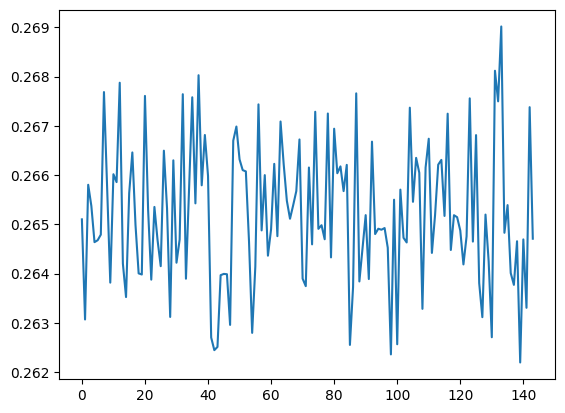

In [48]:
plt.plot(lm1)

In [49]:
x1,x2,yt = next(iter(dl))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cdd072e8ea0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7cdd072e8ea0>  File "/home/mike/6semak/LDB_Summer_Moscow_2024__Task_10/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    
Traceback (most recent call last):
self._shutdown_workers()Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7cdd072e8ea0><function _MultiProcessingDataLoaderIter.__del__ at 0x7cdd072e8ea0>  File "/home/mike/6semak/LDB_Summer_Moscow_2024__Task_10/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/home/mike/6semak/LDB_Summer_Moscow_2024__Task_10/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

        Traceback (most recent call last):

self._shutdown_workers()if w.is_alive():
  File

KeyboardInterrupt: 

In [55]:
(yt.sum(dim=2) > 0).float()[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [60]:
x_proc_1, x_proc_2 = process_data_to_model_bin(x1, x2)
p = m1(x_proc_2, x_proc_1)[0]
(((p - p.min()) / (p.max() - p.min())>0.8).float())

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       device='cuda:0')

In [126]:
(yt.sum(dim=2) > 0).float()[1]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [128]:
x_proc_1, x_proc_2 = process_data_to_model_bin(x1, x2)
p = m1(x_proc_2, x_proc_1)[1]
(((p - p.min()) / (p.max() - p.min())>0.95).float())

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

In [274]:
(yt.sum(dim=2) > 0).float()[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [275]:
x_proc_1, x_proc_2 = process_data_to_model_bin(x1, x2)
p = m1(x_proc_2, x_proc_1)[0]
(((p - p.min()) / (p.max() - p.min())>0.9).float())

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

In [276]:
# If model with incorrect forward

# T.save(m1.state_dict(), f'../models/not_jits_save/day_anomaly_prediction_modded_{str(pd.Timestamp.now()).replace(" ", "T")}.pt')
# model_scripted = T.jit.script(m1)
# model_scripted.save(f'../models/predictors/day_anomaly_prediction_modded_{str(pd.Timestamp.now()).replace(" ", "T")}.pt')

In [1]:
import torch as T

In [50]:
model_scripted = T.jit.script(m1)
model_scripted.save(f'../models/predictors/day_anomaly_prediction_modded_{str(pd.Timestamp.now()).replace(" ", "T")}.pt')

In [61]:
m1 = T.jit.load('../models/predictors/day_anomaly_prediction_modded_2024-06-14T02:08:01.439480.pt')

# Naive model 2

In [42]:
def process_data_to_model_cluster(x1, x2, device=device):
    return T.cat([x1.unsqueeze(1).repeat([1, 213, 1]), x2], axis=2).float().to(device)


In [71]:
class AnomalyDayModelWhatAnomalyDay(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(33, 6, 10, bidirectional=True, batch_first=True)
    def forward(self, x):
        x1, (h1, c1) = self.rnn(x)
        return (ff.tanh(x1) + 1) / 2

In [83]:
what_anomaly_day_model = AnomalyDayModelWhatAnomalyDay()
p = what_anomaly_day_model(process_data_to_model_cluster(x1, x2, 'cpu'))
p.shape

torch.Size([29, 213, 12])

In [84]:
p

tensor([[[0.5190, 0.4580, 0.5393,  ..., 0.6236, 0.4852, 0.4741],
         [0.5420, 0.4366, 0.5625,  ..., 0.6186, 0.4890, 0.4727],
         [0.5604, 0.4244, 0.5757,  ..., 0.6156, 0.4909, 0.4718],
         ...,
         [0.5899, 0.3982, 0.5950,  ..., 0.5967, 0.4996, 0.4842],
         [0.5867, 0.3968, 0.5959,  ..., 0.5837, 0.5038, 0.4868],
         [0.5823, 0.3945, 0.5975,  ..., 0.5566, 0.5075, 0.4906]],

        [[0.5190, 0.4580, 0.5393,  ..., 0.6236, 0.4852, 0.4741],
         [0.5420, 0.4366, 0.5625,  ..., 0.6186, 0.4890, 0.4727],
         [0.5604, 0.4244, 0.5757,  ..., 0.6156, 0.4909, 0.4718],
         ...,
         [0.5899, 0.3982, 0.5950,  ..., 0.5967, 0.4996, 0.4842],
         [0.5867, 0.3968, 0.5959,  ..., 0.5837, 0.5038, 0.4868],
         [0.5823, 0.3945, 0.5975,  ..., 0.5566, 0.5075, 0.4906]],

        [[0.5190, 0.4580, 0.5393,  ..., 0.6236, 0.4852, 0.4741],
         [0.5420, 0.4366, 0.5625,  ..., 0.6186, 0.4890, 0.4726],
         [0.5604, 0.4244, 0.5757,  ..., 0.6156, 0.4909, 0.

In [85]:
m2 = what_anomaly_day_model.to(device)
loss_fun = nn.MSELoss()
optimizer2 = T.optim.Adam(m2.parameters(), lr=0.034) 

In [86]:
lm = []
for e in range(10):
    k = 0
    for x1, x2, yt in tqdm(dl):
        x_proc = process_data_to_model_cluster(x1, x2)
        p = m2(x_proc)
        l = loss_fun(p.float().to('cuda'), yt.float().to('cuda'))
        lm.append(l.item())
        l.backward()
        optimizer2.zero_grad()
        optimizer2.step()
        k+=1
    print(e, np.mean(lm[-k:]), np.min(lm[-k:]))


  0%|          | 0/36 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x74274714be20>
Traceback (most recent call last):
  File "/home/mike/6semak/LDB_Summer_Moscow_2024__Task_10/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/mike/6semak/LDB_Summer_Moscow_2024__Task_10/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/linuxbrew/.linuxbrew/opt/python@3.12/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
          Exception ignored in:  ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x74274714be20>
Traceback (most recent call last):
^  File "/home/mike/6semak/LDB_Summer_Moscow_2024__Task_10/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1

KeyboardInterrupt: 

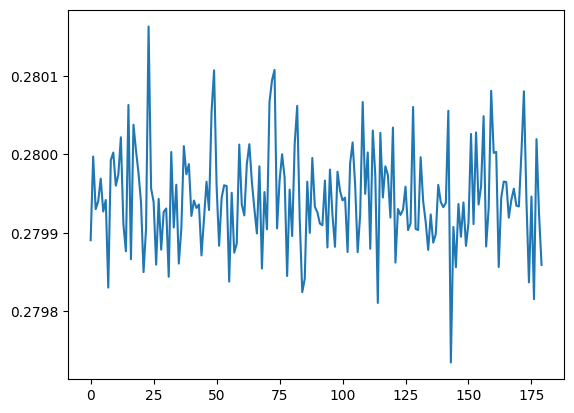

In [76]:
plt.plot(lm)

In [77]:
yt.sum(dim=2).sum(dim=1)

tensor([ 0,  1,  3,  0,  0,  1,  1, 11,  4,  1,  5, 14, 15,  3, 10, 21,  3, 32,
         9,  4,  4, 16, 47,  0,  5, 32,  2,  6,  5])

In [78]:
T.argwhere(yt[2].float().sum(dim=1))

tensor([[18],
        [19],
        [27]])

In [79]:
yt.float()[2][18]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [81]:
p = m2(x_proc)
p[2][18]

tensor([0.4941, 0.5518, 0.4558, 0.6824, 0.3964, 0.4613, 0.6172, 0.5028, 0.5619,
        0.4042, 0.4607, 0.6630], device='cuda:0', grad_fn=<SelectBackward0>)

In [82]:
p[2][40]

tensor([0.4941, 0.5518, 0.4558, 0.6824, 0.3964, 0.4613, 0.6172, 0.5028, 0.5619,
        0.4042, 0.4607, 0.6630], device='cuda:0', grad_fn=<SelectBackward0>)

In [68]:
m2(x_proc)
p_scaled = (p + 1) / 2
p_scaled[2][29]

tensor([0.8190, 0.7489, 0.7940, 0.7261, 0.8115, 0.7463, 0.7041, 0.7769, 0.7813,
        0.7251, 0.7996, 0.8317], device='cuda:0', grad_fn=<SelectBackward0>)

In [82]:
p_scaled[2][29] - p_scaled[2][53]

tensor([ 1.9670e-06, -4.7684e-07, -4.7088e-06, -3.0398e-06,  6.0201e-06,
        -1.6093e-06,  0.0000e+00, -4.7684e-07, -4.1723e-06,  1.7881e-07,
         2.6822e-07, -5.9605e-07], device='cuda:0', grad_fn=<SubBackward0>)

In [ ]:
model_scripted = T.jit.script(m2)
model_scripted.save(f'../models/predictors/day_anomaly_prediction_cluster_modded_{str(pd.Timestamp.now()).replace(" ", "T")}.pt')

# **Hours model**

## Dataset

In [65]:
class DataSetForHoursAnomalyPredictionForNN(Dataset):
    def __init__(self, 
        buildings_df: pd.DataFrame, 
        anomalies_ts: pd.DataFrame, 
        weather_ts: pd.DataFrame, 
        # time='day',
    ):
        self.buildings_df = buildings_df
        self.anomalies_ts = anomalies_ts
        self.weather_ts = weather_ts
        self.unom_ids = np.unique(self.buildings_df['UNOM'].astype(int).to_list() + self.anomalies_ts['UNOM'].astype(int).to_list())
        self.tl = make_timeline_for_period(2023, 24)
        z1, z2 = np.unique(self.anomalies_ts.loc[:, ['days', 'UNOM']].drop_duplicates()['UNOM'].to_numpy(), return_counts=True)
        # z2 = np.arange(len(z1))
        self.day_id_unom = [np.full(i, j).tolist() for i, j in zip(z2, z1)]
        self.day_index = np.array(sum(self.day_id_unom, []))
        
    
    def __len__(self):
        return len(self.day_index)

    def __getitem__(self, idx):
        
        unom_id = self.day_index[idx]
        day_idx = np.argwhere(self.day_index[:idx+1] == unom_id)[:, 0].shape[0]-1
        building_info = self.buildings_df.loc[self.buildings_df['UNOM'] == unom_id].fillna(-1)
        anomalies_info = self.anomalies_ts.loc[self.anomalies_ts['UNOM'] == unom_id]
        day = anomalies_info['days'].unique()[day_idx]
        anomalies_info = anomalies_info.loc[anomalies_info['days'] == day]
        # print(idx, day)
        weather_timeline = np.arange(datetime(year=day.year, month=day.month, day=day.day), datetime(year=day.year, month=day.month, day=day.day)+timedelta(days=1), timedelta(hours=1))
        anomaly_timeline = pd.DataFrame({'houres':np.arange(datetime(year=day.year, month=day.month, day=day.day, hour=0), datetime(year=day.year, month=day.month, day=day.day)+timedelta(days=1), timedelta(hours=1))})
        anomalies = pd.merge(anomaly_timeline, anomalies_info, how='left', on='houres').drop(
            ['Дата закрытия', 'Дата создания во внешней системе', 'days', 'UNOM',], axis=1
        ).drop_duplicates().fillna(0).drop('houres', axis=1)
        weathers = self.weather_ts.loc[self.weather_ts['houres'].isin(weather_timeline)].drop(
            ['timeline', 'houres', 'days'], axis=1
        )
        
        if anomalies.shape[0] == 0:
            bt = T.zeros(anomalies.shape[1])
        elif anomalies.shape[0] > 1:
            bt = T.from_numpy(building_info.values).sum(dim=0)
            # print(idx)
        else:
            bt = T.from_numpy(building_info.values)
        if weathers.shape[0] == 0:
            wt = T.zeros(24, 15)
        else:
            wt = T.from_numpy(weathers.values)[:70, :]
        return bt, T.from_numpy(anomalies.values)[:24, :], wt
        

In [67]:
d = DataSetForHoursAnomalyPredictionForNN(
    anomalies_ts=anomalies_ts,
    weather_ts=weather_ts,
    buildings_df=buildings_df
)

dl = DataLoader(d, batch_size=128, shuffle=True, num_workers=0)

x1, x2, yt = next(iter(dl))

## Naive Model

In [69]:
x1.shape, x2.shape, yt.shape

(torch.Size([128, 19]), torch.Size([128, 24, 12]), torch.Size([128, 24, 15]))

In [94]:
nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(2, 2), padding=2, stride=1),
    # nn.MaxPool2d(kernel_size=(2, 2), padding=1),
)(x2.float().unsqueeze(1)).shape

torch.Size([128, 8, 27, 15])

In [70]:
class AnomalyDayModelTSEncoderConved(nn.Module):
    def __init__(self):
        super().__init__()
        self.m = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 2), padding=2),
            nn.AvgPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=2),
            nn.MaxPool2d(kernel_size=(2, 1)),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=2),
            nn.AvgPool2d(kernel_size=(2, 1)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=2),
            nn.AvgPool2d(kernel_size=(2, 1)),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=2),
            nn.MaxPool2d(kernel_size=(3, 3)),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.AvgPool2d(kernel_size=(3, 3)),
            nn.Flatten(1),
        )
    def forward(self, x):
        return ff.tanh(self.m(x))

tensor([[ 6.9572e-01,  8.7212e-02,  0.0000e+00,  ...,  0.0000e+00,
          3.6000e-01,  6.5074e+04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 7.4804e-01,  2.4466e-01, -1.0000e+00,  ...,  0.0000e+00,
          1.6000e-01,  1.8060e+04],
        ...,
        [ 7.5223e-01,  2.5876e-01, -1.0000e+00,  ...,  0.0000e+00,
          3.2000e-01,  2.9216e+04],
        [ 7.6300e-01,  2.8929e-01, -1.0000e+00,  ...,  0.0000e+00,
          3.2000e-01,  1.1740e+04],
        [ 7.4644e-01,  2.4370e-01, -1.0000e+00,  ...,  0.0000e+00,
          1.6000e-01,  1.3844e+04]], dtype=torch.float64)